In [19]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

%matplotlib inline

# Abstract

Values of $W$ were collected for various stochastic realizations of an overdamped Langevin dynamics simulation. Since the internal energy was modeled by a potential well $U(x)=\frac{k}{2}(x-\lambda)^2$ with a minimum of $\lambda$, this created a Gaussian when it was plugged into the Boltzmann factor $p\propto e^{-\beta E}$. We show that the Jarzynski sum, which we call an estimator, $\overline{e^{-\beta W}} \approx e^{-\beta\Delta F}$, is **consistent** in overdamped Langevin dynamics.

We show that it is consistent by showing that its value gets closer and closer to 1 as the number of measurements increases with a zero free energy difference.

# Introduction/Hypothesis

The Jarzynski equality in stochastic thermodynamics is $$\langle e^{-\beta W} \rangle = e^{-\beta\Delta F}$$,

relating an average of stochastic work trajectories to the free energy difference between two ensemble states, at least one of which must be in equilibrium.

One thing which is striking about this equation in the context of this course is how it relates to the convergence of consistent estimators to the true value.

For a finite sample, we might say the sample mean $\overline{e^{-\beta W}}\approx \langle e^{-\beta W} \rangle$ is an estimator of the term  $e^{-\beta\Delta F}$.

The hypothesis of this case study is that: **The estimator** $\overline{e^{-\beta W}}\approx e^{-\beta\Delta F}$ **is consistent.** If this is true, then we would expect the sum $\overline{e^{-\beta W}}$ typically gets closer in value to $e^{-\beta\Delta F}$ as the number of data points for $W$ increases.

We skip the unbiasedness of $\overline{e^{-\beta W}}\approx e^{-\beta\Delta F}$ because that is implied by the statement of the Jarzynski equality itself.

# Data Acquisition 

In [108]:
#thermal parameters
k = 1.0 # spring constant
γ = 1.0 # friction coefficient
beta = 1.0 # k_B T, thermodynamic temperature
D = 1/beta/γ
σ_noise = np.sqrt(2*D*dt)

#temporal parameters
τ = 1.0 # simulation duration
num_steps = 1000
time_series = np.linspace(0, τ, num_steps)
dt = τ/num_steps
number_trajectories = 1000 #increasing this number did not improve the point

λ_A = 1#initial value of the protocol
λ_B = 2#final value of the protocol

Values of $W$ were collected for various stochastic realizations of an overdamped langevin dynamics simulation. 

A harmonic spring potential energy was used, 
$$U(x, \lambda)=\frac{1}{2}k(x-\lambda)^2$$
with the resulting partition function (no kinetic energy considered)
$$Z(\lambda)=\int_{-\infty}^{+\infty} e^{-\beta U(x, \lambda)}dx=\int_{-\infty}^{+\infty} e^{-\beta \frac{1}{2}k(x-\lambda)^2}dx= \sqrt{\frac{2\pi k_B T}{k}}$$
which is the prefactor of a Gaussian distribution with standard deviation $\sigma=\frac{k_BT}{k}$.

Since the internal energy was modeled by a potential well $U(x)=\frac{k}{2}(x-\lambda)^2$ with a minimum of $\lambda$, this created a Gaussian when it was plugged into the Boltzmann factor $p\propto e^{-\beta E}$. That way, the partition function $Z$ ended up the same for different choice of $\lambda$.

Then the partition function does not depend on the protocol $\lambda$, and

$$Z(\lambda_A)=Z(\lambda_B)=\sqrt{\frac{2\pi k_B T}{k}}$$
$$\Delta F = F(\lambda_B)-F(\lambda_A)=-k_B T\ln \frac{Z(\lambda_B)}{Z(\lambda_A)}=-k_B T\ln 1 = 0$$

Therefore an ensemble average from the simulation(s) should confirm the result

$$\overline{e^{-\beta W}} \approx e^{-\beta\Delta F}=1,$$

from the Jarzynski work relation.

In [126]:
def langevin_work(λ_A, λ_B, forward=True, plot_x=False):

    if forward: #forward protocol
       λ_0, λ_f = λ_A, λ_B #start at the first input, end at the second input
    else: #reverse protocol.
       λ_0, λ_f = λ_B, λ_A #start at the second input, end at the first input

    #x = 0.0
    x = np.random.normal(loc=λ_0, scale=np.sqrt(1 / beta / k))
    W = 0.0 #total work
    
    λ_t = λ_0 #current value of lambda
    dλdt = (time_series[-1]-time_series[0])/ τ

    x_series = [x]
    for step, time in enumerate(time_series):

        #distinguishing the λ value at this time-sampe from the one with which we are doing force calculations
        λ_previous = λ_t #do force calculations with λ_previous
        λ_t = λ_previous + dλdt*dt
        spring_force = -k*(x-λ_previous) #-dU/dx=-k*(x-λ)

        #the value of the work is constructed from the following differential terms:
        #dW=dU/dλ*dλ, dU/dλ=-k*(x-λ), dλ = dλ/dt*dt
        dW=-k*(x-λ_previous)*dλdt*dt
        W += dW
        
        ξ = np.random.normal(0.0, σ_noise)
        dx = spring_force/γ * dt + ξ
        x += dx
        x_series.append(x)
        
    if plot_x:
        return x_series, W
    else:
        return W

In [127]:
#just running one to test
λ_A, λ_B = -10, 10 
work_data = np.array([langevin_work(λ_A, λ_B) for _ in range(number_trajectories)])
jarzynski_sum = np.mean(np.exp(-beta*work_data))

In [129]:
print(jarzynski_sum)

0.9944438910920964


The expression $\overline{e^{-\beta W}}$ is represented by the object `jarzynski_sum`. The reason we do not see a perfect $\overline{e^{-\beta W}}=1$ is primarily because of limited data points (Langevin work trajectories).

As you can see from the below analysis and visualization, an increase in the number of trajectories brings the convergence closer to $\overline{e^{-\beta W}}=1$. Furthermore, if a potential energy function were chosen such that the partition function depends on the work protocol (e.g. the density is not Gaussian), then $e^{-\beta\Delta F}$ would be a different numerical value.

In [175]:
import pandas as pd

#we test the amount of data it takes for the ensemble average to converge by looping over different numbers of trajectories
numbers_of_trajectories = [5, 10, 50, 100, 250, 500, 600, 700, 800, 900, 1000]


jarzynski_sum_column =  []
work_data_column = []

for N in numbers_of_trajectories:
    work_data = np.array([langevin_work(λ_A, λ_B) for _ in range(N)]) 
    work_data_column.append(work_data)
    jarzynski_sum = np.mean(np.exp(-beta*work_data))
    jarzynski_sum_column.append(jarzynski_sum)

# Data Analysis and Visualization

The first plot we visit is a simple look at the motion of the particles whose realizations we are studying.

That code generates data to test the Jarzynski relation by going thousands of trajectories. In the following code we generate a single trajectory instead, just the visualize the motion of the particle.

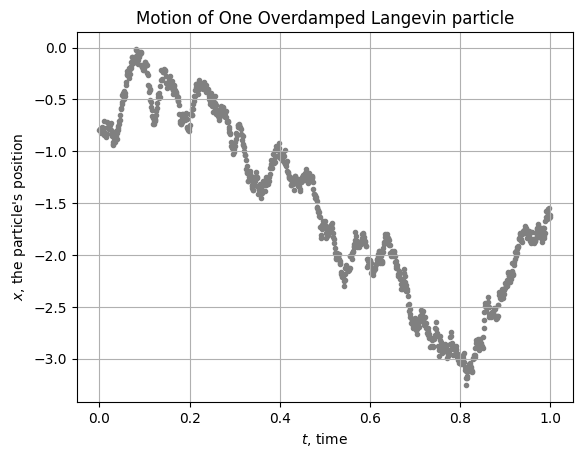

In [177]:
#visualization of a single trajectory
λ_A, λ_B = -1, 1 
single_x_trajectory, single_w = langevin_work(λ_A, λ_B, plot_x=True)

plt.scatter(time_series, single_x_trajectory[:-1], marker='.', color='gray')
plt.xlabel(r'$t$, time')
plt.ylabel(r"$x$, the particle's position")
plt.title('Motion of One Overdamped Langevin particle')
plt.grid()
plt.show()

The second plot is a test of the consistency of the Jarzynski estimator.

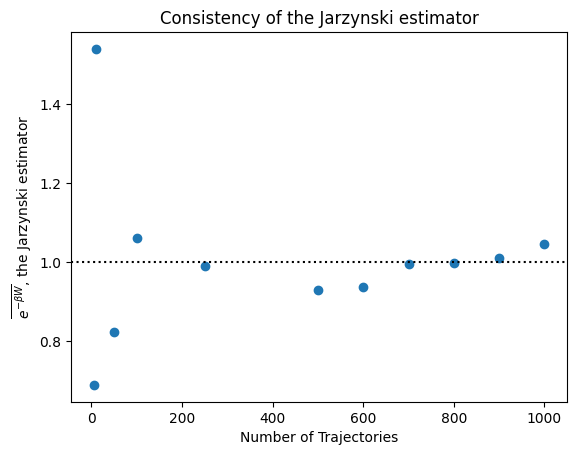

In [176]:
df = pd.DataFrame({"N" : numbers_of_trajectories,
                   r"$\overline{e^{-\beta W}}$" : jarzynski_sum_column})
df.head()

plt.scatter(df["N"], df[r"$\overline{e^{-\beta W}}$"])
plt.xlabel('Number of Trajectories')
plt.ylabel(r"$\overline{e^{-\beta W}}$, the Jarzynski estimator")
plt.axhline(1, linestyle='dotted', color='black', label=r'$e^{-\beta\Delta F}=1$')
plt.title('Consistency of the Jarzynski estimator')
plt.show()

# Conclusion.

One aspect of the chemical significance of this result is that more work measurements leads to a better estimate of the free energy difference between equilibrium states.

The hypothesis that the estimator on the left-hand side of the Jarzynski equality is a **consistent estimator,** at least for overdamped Langevin dynamics. A good direction for further research would be the investigation of underdamped Langevin dynamics and the investigation of nonzero free energy differences.

# References

1. Sekimoto, Ken. *Stochastic Energetics*. Springer, 2010.
2. Jarzynski, C. "Microscopic Analysis of Clausius--Duhem Processes." *Journal of Statistical Physics*, vol. 96, 1999, pp. 415--427. Springer.
3. Crooks, Gavin E. "Entropy Production Fluctuation Theorem and the Nonequilibrium Work Relation for Free Energy Differences." *Physical Review E*, vol. 60, no. 3, 1999, p. 2721. APS.
4. Nicholson, Schuyler B., Luis Pedro García-Pintos, Adolfo del Campo, and Jason R. Green. "Time--Information Uncertainty Relations in Thermodynamics." *Nature Physics*, vol. 16, no. 12, 2020, pp. 1211--1215. Nature Publishing Group UK London. 